In [144]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf

In [145]:
tsla = yf.Ticker("tsla")

tsla_hist = tsla.history(period='5y', interval='1d', end='2025-06-13')
tsla_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-06-19 00:00:00-04:00,67.518669,67.731331,66.089333,66.726669,130195500,0.0,0.0
2020-06-22 00:00:00-04:00,66.663330,67.258667,66.001335,66.288002,95436000,0.0,0.0
2020-06-23 00:00:00-04:00,66.592003,67.466667,66.267334,66.785332,95479500,0.0,0.0
2020-06-24 00:00:00-04:00,66.274002,66.725334,63.542667,64.056664,164394000,0.0,0.0
2020-06-25 00:00:00-04:00,63.618000,65.732002,62.476665,65.732002,138817500,0.0,0.0
...,...,...,...,...,...,...,...
2025-06-11 00:00:00-04:00,334.399994,335.500000,322.500000,326.429993,122611400,0.0,0.0
2025-06-12 00:00:00-04:00,323.079987,332.559998,316.859985,319.109985,105127500,0.0,0.0
2025-06-13 00:00:00-04:00,313.970001,332.989990,313.299988,325.309998,128964300,0.0,0.0


In [146]:
tsla_hist.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

In [147]:
tsla_hist.index =pd.to_numeric(tsla_hist.index)
tsla_hist.index = tsla_hist.index/(max(tsla_hist.index))

In [148]:
for col in tsla_hist.columns:
    tsla_hist[col] = tsla_hist[col]/max(tsla_hist[col])

In [149]:
X = tsla_hist.drop(columns=['Close'])
y = tsla_hist['Close']

In [150]:
X['Date'] = X.index

In [151]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

pca.fit(X, y)

PCA(n_components=5)

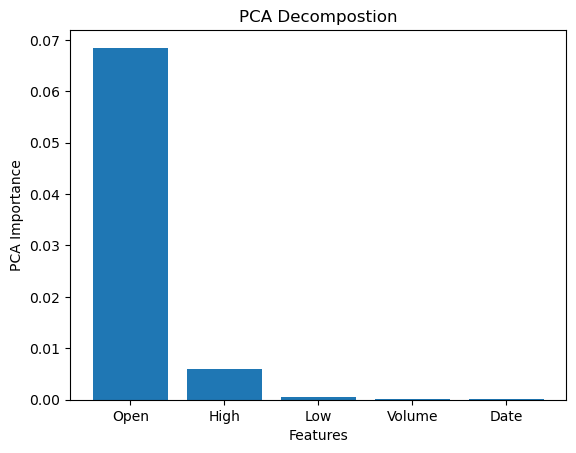

In [152]:
import matplotlib.pyplot as plt

plt.bar(X.columns, pca.explained_variance_)
plt.xlabel('Features')
plt.ylabel('PCA Importance')
plt.title("PCA Decompostion")
plt.show()

In [153]:
for delay in range(1,4):
    X[f"Delay {delay}"] = y.iloc[(3-delay):-(delay)]

In [154]:
X

,Open,High,Low,Volume,Date,Delay 1,Delay 2,Delay 3
Date,,,,,,,,
0.909953,0.141876,0.138640,0.144454,0.195378,0.909953,NaN,NaN,0.139054
0.910101,0.140078,0.137673,0.144262,0.143216,0.910101,NaN,0.138140,0.138140
0.910151,0.139929,0.138099,0.144843,0.143281,0.910151,0.139177,0.139177,0.139177
0.910200,0.139260,0.136581,0.138888,0.246698,0.910200,0.133490,0.133490,0.133490
0.910250,0.133679,0.134548,0.136558,0.208316,0.910250,0.136982,0.136982,0.136982
...,...,...,...,...,...,...,...,...
0.999704,0.702669,0.686740,0.704903,0.183997,0.999704,0.680261,0.680261,0.680261
0.999753,0.678882,0.680722,0.692575,0.157759,0.999753,0.665006,0.665006,0.665006
0.999803,0.659739,0.681602,0.684794,0.193530,0.999803,0.677927,0.677927,NaN


In [155]:
X_sample = [[d, h, l, o, vol, v1, v2, v3] for d, h, l, o, vol, v1, v2, v3 in zip(X['Date'].iloc[3:].values, X['High'].iloc[3:].values, X['Low'].iloc[3:].values,X['Open'].iloc[3:].values, X['Volume'].iloc[3:].values, X['Delay 1'].dropna().values, X['Delay 2'].dropna().values, X['Delay 3'].dropna().values)]
y_sample = y.iloc[3:].values

In [156]:
len(X['Date'].iloc[3:].values), len(X_sample)

(1252, 1252)

In [157]:
len(y_sample), len(X_sample)

(1252, 1252)

In [158]:
torch.set_default_dtype(torch.float64)

In [159]:
X = torch.from_numpy(np.array(X))
y = torch.from_numpy(np.array(y))

In [160]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [161]:
len(X_test)

251

In [162]:
train_data = [(X,y) for X, y in zip(X[:-273], y[:-273])]
test_data = [(X,y) for X, y in zip(X[-273:], y[-273:])]

In [163]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloaader= DataLoader(test_data, batch_size=32, shuffle=True)

In [164]:
class MLP(nn.Module):
    def __init__(self, input_features, hidden_features, output_features):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_features),
            nn.ReLU()
        )
        self.l2 = nn.Sequential(
            nn.Linear(in_features=hidden_features, out_features=15),
            nn.ReLU()
        )
        self.l3 = nn.Linear(in_features=15, out_features=output_features)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

In [165]:
mlpmodel = MLP(8, 15, 1)

In [166]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(params=mlpmodel.parameters(), lr=0.0001)

In [167]:
EPOCHS = 1

mlpmodel.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        preds = mlpmodel(X)
        print(f"Preds + {preds}")
        loss = loss_fn(torch.unsqueeze(y, 1), preds)
        total_loss+= loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(f"We're on batch: {batch} + Loss: {total_loss/batch}")


Preds + tensor([[0.0000, 0.0000, 0.1916, 0.0747, 0.0000, 0.0000, 0.0000, 0.0000, 0.4684,
         0.0000, 0.0000, 0.1208, 0.3145, 0.3356, 0.0000],
        [0.0000, 0.0000, 0.2038, 0.0549, 0.0000, 0.0000, 0.0000, 0.0000, 0.3728,
         0.0000, 0.0000, 0.1189, 0.2913, 0.3075, 0.0000],
        [0.0000, 0.0000, 0.2302, 0.0382, 0.0000, 0.0000, 0.0000, 0.0000, 0.2609,
         0.0479, 0.0000, 0.1009, 0.2662, 0.2896, 0.0000],
        [0.0000, 0.0000, 0.2516, 0.0539, 0.0000, 0.0000, 0.0000, 0.0000, 0.2863,
         0.0397, 0.0000, 0.0854, 0.2747, 0.3083, 0.0000],
        [0.0000, 0.0000, 0.1995, 0.0582, 0.0000, 0.0000, 0.0000, 0.0000, 0.3876,
         0.0000, 0.0000, 0.1282, 0.2941, 0.3085, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.0647, 0.0000, 0.0000, 0.0000, 0.0000, 0.4341,
         0.0000, 0.0000, 0.1287, 0.3057, 0.3187, 0.0000],
        [0.0000, 0.0000, 0.1869, 0.0632, 0.0000, 0.0000, 0.0000, 0.0000, 0.4315,
         0.0000, 0.0000, 0.1315, 0.3043, 0.3158, 0.0000],
        [0.0000, 0.

c:\Users\rahul\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 15])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\rahul\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([22, 15])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
